# DC electric response in cylindrical coordinates

Here we test the capacity of Simpeg to solve the DC problem in cylindrical coordinates. We consider a homogeneous conductivity model and compare against the analytic solution. We test different grid discretizations and compare the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from discretize import CylindricalMesh, TreeMesh
from SimPEG import maps
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    apparent_resistivity_from_voltage,
)
from SimPEG import utils
try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

## Create Cylindrical Mesh

We first create two Cylindrical meshes. The first mesh is a fine mesh that was optimized by hand to achieve the best precision. The second mesh is coarser, but will achieve a good enough precision.

In [2]:
#Best
hr = [(0.00001, 40, 1.01),  (0.0001, 80, 1.01), (0.001, 160, 1.01), (0.01, 180, 1.01), (0.04, 80, 1.12)]
hz = [ (0.02, 80, -1.12), (0.01, 180, -1.01), (0.001, 80, -1.01), (0.0001, 40, -1.01), (0.00001, 40, -1.01), (0.00001, 40, 1.01), (0.0001, 40, 1.01), (0.001, 80, 1.01),  (0.01, 180, 1.01), (0.02, 80, 1.12)]

mesh_best = CylindricalMesh([hr, 1, hz], x0="00C")
print("the mesh has {} cells".format(mesh_best.nC))

the mesh has 453600 cells


In [3]:
#Fastest, but still accurate enough
hr = [(0.0001, 200, 1.05), (1.2, 40, 1.12)]
hz = [ (1.2, 40, -1.12), (0.0001, 200, -1.05), (0.0001, 200, 1.05), (1.2, 40, 1.12)]

mesh_fast = CylindricalMesh([hr, 1, hz], x0="00C")
print("the mesh has {} cells".format(mesh_fast.nC))

the mesh has 115200 cells


Here, we plot the meshes. Note that the mesh is a cylindrical mesh, so we plot the mesh in the r-z plane. You can visualize the mesh at different scales by changing the xlim and ylim arguments.

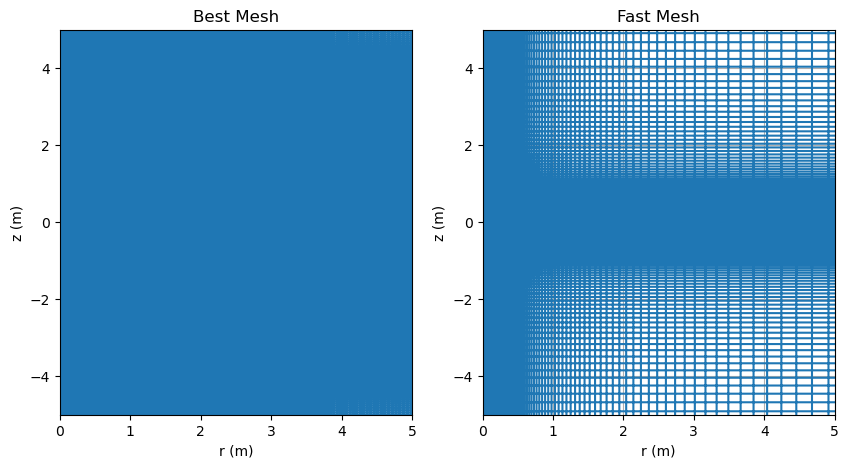

In [4]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
mesh_best.plot_grid(ax=ax1)
ax1.set_title("Best Mesh")
ax1.set_xlabel("r (m)")
ax1.set_ylabel("z (m)")
ax1.set_ylim([-5,5])
ax1.set_xlim([0,5])
mesh_fast.plot_grid(ax=ax2)
ax2.set_title("Fast Mesh")
ax2.set_xlabel("r (m)")
ax2.set_ylabel("z (m)")
ax2.set_ylim([-5,5])
ax2.set_xlim([0,5])
plt.show()

## Create Conductivity/Resistivity Model and Mapping

Here, we create the model that will be used to predict DC potential. We create an homogeneous model to be able to compare with the analytic solution. The model consists of a background conductivity of $10^{-2}$ S/m.

In [5]:
# Define conductivity model in S/m (or resistivity model in Ohm m)
background_value = 1e-2
sigma_best = np.ones(mesh_best.nC) * background_value
sigmamap_best = maps.IdentityMap(mesh_best)

sigma_fast = np.ones(mesh_fast.nC) * background_value
sigmamap_fast = maps.IdentityMap(mesh_fast)

## Create Survey
To model the data, we create a survey. We here use a pole-pole configuration. To do this, we need to define the source and receiver locations. For this tutorial, we will keep it simple and use a single source pole located at the origin.
We need to set the receiver position to be able to look at the solution in the vincinity of the source, and generate a regular grid of receivers.

In [6]:
rtemp = np.arange(0.02, 5, 0.02)
ztemp = np.arange(-5, 5, 0.02)
xyz_rxM = utils.ndgrid(rtemp, np.r_[0.0], ztemp)

In [7]:
receivers = dc.receivers.Pole(xyz_rxM)
sources = dc.sources.Pole(receivers,(0, 0, 0))
survey = dc.Survey(sources)

## Create a DC Simulation
We now perform a DC simulation. We use the user defined solver and the mapping defined above. The boundary conditions must be defined as a dictionary. Here, we use Dirichlet boundary conditions, where we enforce the potential to be 0 on the top and bottom of the cylinder and at infinity.

In [8]:
simulation_best = dc.simulation.Simulation3DCellCentered(
    mesh_best, survey=survey,  sigmaMap=sigmamap_best, solver=Solver, bc_type='Dirichlet'
)
simulation_fast = dc.simulation.Simulation3DCellCentered(
    mesh_fast, survey=survey,  sigmaMap=sigmamap_fast, solver=Solver, bc_type='Dirichlet'
)

In [9]:
t0 = time.time()
dpred_best = simulation_best.dpred(sigma_best)
t1 = time.time()
dpred_fast = simulation_fast.dpred(sigma_fast)
t2 = time.time()
print("Best mesh: {} s".format(t1-t0))
print("Fast mesh: {} s".format(t2-t1))

Best mesh: 4.665914058685303 s
Fast mesh: 1.162703275680542 s


## Comparison with Analytic Solution

The analytic solution for a pole-pole survey over a cylinder is given by:

$$
V = \frac{I}{4\pi\sigma \sqrt{r^2 + z^2}}
$$

where $I$ is the source current, $\sigma$ is the conductivity, $r$ is the radial distance from the source, and $z$ is the vertical distance from the source. We can compare the analytic solution with the numerical solution.

In [10]:
analytic = 1/(background_value * 4*np.pi * np.sqrt(xyz_rxM[:,0]**2 + xyz_rxM[:,2]**2))

Visually, the solutions are very similar.

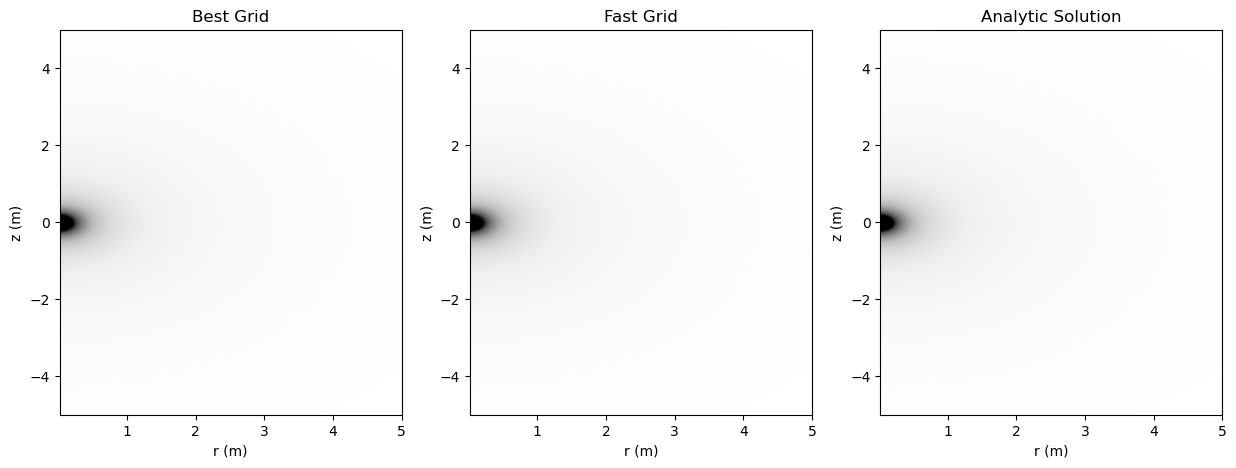

In [11]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
vmin = analytic.min()
vmax = analytic.max() * 0.1
ax1.imshow(dpred_best.reshape((250, 500), order="F").T,
           interpolation="bilinear", cmap="Greys", aspect="auto",
           vmin=vmin, vmax=vmax,
           extent=[rtemp.min(), rtemp.max(), ztemp.min(), ztemp.max()])
ax1.set_title("Best Grid")
ax1.set_xlabel("r (m)")
ax1.set_ylabel("z (m)")
ax2.imshow(dpred_fast.reshape((250, 500), order="F").T,
           interpolation="bilinear", cmap="Greys", aspect="auto",
           vmin=vmin, vmax=vmax,
           extent=[rtemp.min(), rtemp.max(), ztemp.min(), ztemp.max()])
ax2.set_title("Fast Grid")
ax2.set_xlabel("r (m)")
ax2.set_ylabel("z (m)")

ax3.imshow(analytic.reshape((250, 500), order="F").T,
           interpolation="bilinear", cmap="Greys", aspect="auto",
           vmin=vmin, vmax=vmax,
           extent=[rtemp.min(), rtemp.max(), ztemp.min(), ztemp.max()])
ax3.set_title("Analytic Solution")
ax3.set_xlabel("r (m)")
ax3.set_ylabel("z (m)")
plt.show()


We can also look at the relative error.

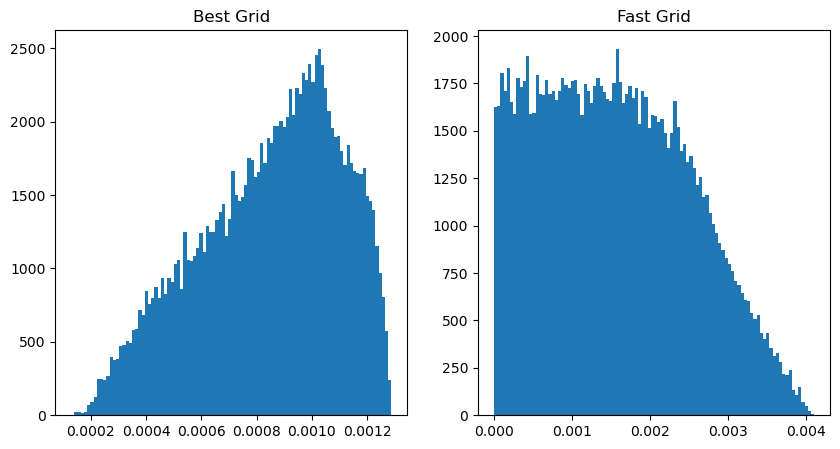

In [12]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(np.sqrt((analytic-dpred_best)**2)/np.sqrt(dpred_best**2), bins=100)
ax1.set_title("Best Grid")
ax2.hist(np.sqrt((analytic-dpred_fast)**2)/np.sqrt(dpred_fast**2), bins=100)
ax2.set_title("Fast Grid")
plt.show()

The relative error is less than 0.13 % for the best grid and less than 0.5 % for the fast grid and the best grid is nearly 5 times more accurate than the fast grid.

In [13]:
print("norm of the error for best grid is %f" % (np.linalg.norm(analytic-dpred_best) / np.linalg.norm(analytic)))
print("norm of the error for fast grid is %f" % (np.linalg.norm(analytic-dpred_fast) / np.linalg.norm(analytic)))

norm of the error for best grid is 0.000494
norm of the error for fast grid is 0.001443


We can compute the apparent resistivity from the potential data, which should have a constant value of 100 Ohm-m.

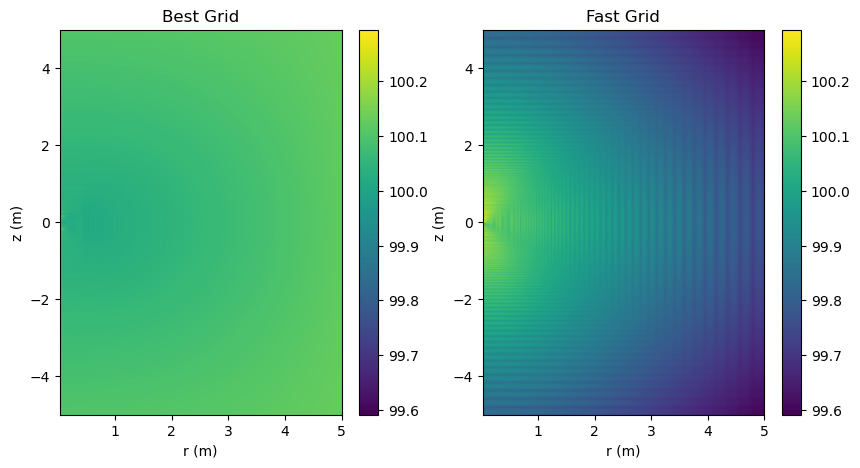

In [14]:
rhoa_best = apparent_resistivity_from_voltage(survey, dpred_best, space_type="whole-space")
rhoa_fast = apparent_resistivity_from_voltage(survey, dpred_fast, space_type="whole-space")
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
vmin = np.min([rhoa_best.min(), rhoa_fast.min()])
vmax = np.max([rhoa_best.max(), rhoa_fast.max()])
im = ax1.imshow(rhoa_best.reshape((250, 500), order="F").T,
           interpolation="bilinear", aspect="auto",
                vmin=vmin, vmax=vmax,
            extent=[rtemp.min(), rtemp.max(), ztemp.min(), ztemp.max()])
plt.colorbar(im)
ax1.set_title("Best Grid")
ax1.set_xlabel("r (m)")
ax1.set_ylabel("z (m)")
im = ax2.imshow(rhoa_fast.reshape((250, 500), order="F").T,
           interpolation="bilinear", aspect="auto",
                vmin=vmin, vmax=vmax,
            extent=[rtemp.min(), rtemp.max(), ztemp.min(), ztemp.max()])
plt.colorbar(im)
ax2.set_title("Fast Grid")
ax2.set_xlabel("r (m)")
ax2.set_ylabel("z (m)")
plt.show()

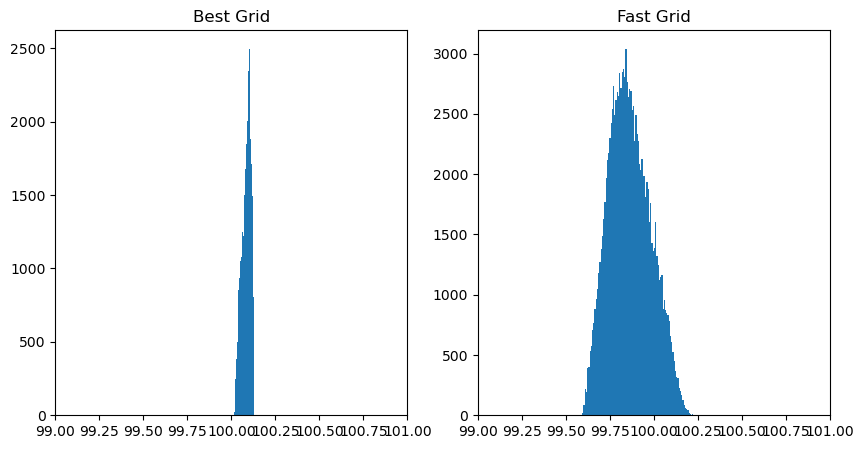

In [15]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(rhoa_best, bins=100)
ax1.set_xlim([99, 101])
ax1.set_title("Best Grid")
ax2.hist(rhoa_fast, bins=100)
ax2.set_xlim([99, 101])
ax2.set_title("Fast Grid")
plt.show()

The apparent resistivity is very close to 100 Ohm-m for both grids, but the spread is much lower for the best grid.

## Treemesh

We can compare the cylindrical mesh to a full 3D mesh in terms of accuracy and run time. We will use a treemesh here, which is a quadtree in 2D and an octree in 3D. We will use the same cell size as the cylindrical mesh, but we will refine the mesh around the electrodes.

In [ ]:
dh = 0.0025  # base cell width
dom_width = 1000
nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))
h = [(dh, nbc)]
treemesh = TreeMesh([h, h, h], x0="CCC", diagonal_balance=True,
                    max_level=10)
treemesh.refine_box(x0s =[-8,-8, -8], x1s=[8, 8, 8], levels=-7, finalize=False)
treemesh.refine_box(x0s =[-4,-4,-4], x1s=[4, 4, 4], levels=-6, finalize=False)
treemesh.refine_box(x0s =[-2,-2, -2], x1s=[2, 2, 2], levels=-5, finalize=False)
treemesh.refine_box(x0s =[-1,-1, -1], x1s=[1, 1, 1], levels=-4, finalize=False)
treemesh.refine_box(x0s =[-0.5,-0.5, -0.5], x1s=[0.5, 0.5, 0.5], levels=-3, finalize=False)
treemesh.refine_box(x0s =[-0.25,-0.25, -0.25], x1s=[0.25, 0.25, 0.25], levels=-2, finalize=False)
treemesh.refine_box(x0s =[-0.125,-0.125, -0.125], x1s=[0.125, 0.125, 0.125], levels=-1, finalize=False)
print("the mesh has {} cells".format(mesh_best.nC))

Mesh generation takes a long time, because the cartesian grid is 3D and very large.

We set up the simulation as before and compute the predicted data.

In [ ]:
treesigma = np.ones(treemesh.nC) * background_value
treesigmamap = maps.IdentityMap(treemesh)
simulation = dc.simulation.Simulation3DCellCentered(
    treemesh, survey=survey,  sigmaMap=treesigmamap, solver=Solver, bc_type='Dirichlet'
)

In [32]:
t1 = time.time()
treedpred = simulation.dpred(treesigma)
t2 = time.time()
print("Run time for treemesh is %f" % (t2-t1))

The run time is much longer than for the cylindrical mesh.

We can measure the accuracy of the treemesh solution by computing the relative error.

In [ ]:
np.linalg.norm(analytic-treedpred) / np.linalg.norm(analytic)

In [33]:
rhoa = apparent_resistivity_from_voltage(survey, treedpred, space_type="whole-space")

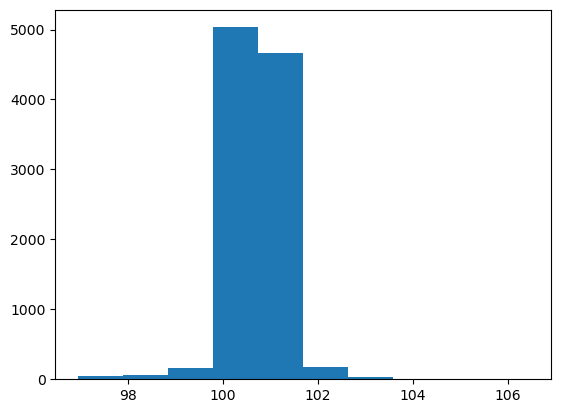

In [34]:
plt.hist(rhoa)
plt.show()

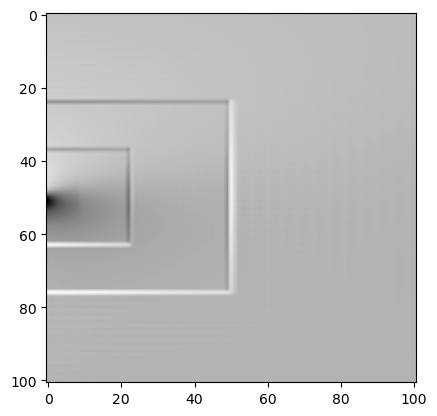

In [35]:
plt.imshow(rhoa.reshape((101, 101), order="F").T,
           interpolation="bilinear", cmap="Greys")

In [36]:
np.linalg.norm(analytic-treedpred) / np.linalg.norm(analytic)

0.018862799443378674